In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import matplotlib.pyplot as plt
from datetime import datetime

#machine learning packages
import sklearn
import sklearn.metrics
from sklearn.utils import shuffle, class_weight
from matplotlib import pyplot as plt

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Multiply, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km

from models.v8 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

%matplotlib inline

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-c', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-i', '--in_dir', type=str, help='directory containing 01_data_encoding intermediate tsv files')

#simulate command line input
cmdline_str='-c ' + " HepG2,K562 " + \
    ' -i ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_2overlap/ATAC/"

seq_names = ["ATAC", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
print("all files found!")

all files found!


In [3]:
def get_data(cell_types, in_dir, seq_names):

    first_cell = True
    for cell in cell_types:
        print(cell)

        pos = []
        neg = []
        first_seq = True
        for seq in seq_names:
            print("-"+seq)

            pos_name = in_dir+cell+"."+seq+".pos.tsv"
            pos_mat = np.loadtxt(pos_name, delimiter='\t')

            neg_name = in_dir+cell+"."+seq+".neg.tsv"
            neg_mat = np.loadtxt(neg_name, delimiter='\t')

            if first_seq:
                for i in pos_mat:
                    pos.append(np.array([i]))
                for i in neg_mat:
                    neg.append(np.array([i]))
                first_seq = False
            else:
                for i in range(len(pos)):
                    pos[i] = np.vstack((pos[i], pos_mat[i,]))
                for i in range(len(neg)):
                    neg[i] = np.vstack((neg[i], neg_mat[i,]))

        if first_cell == True:
            X_pos = np.array(pos)
            X_neg = np.array(neg)
            first_cell = False
        else:
            X_pos = np.vstack((X_pos, pos))
            X_neg = np.vstack((X_neg, neg))

    X = np.vstack((X_pos, X_neg))
    y = np.array([1 for i in range(X_pos.shape[0])] + [0 for i in range(X_neg.shape[0])]).reshape(-1,1)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [4]:
#collect the output of the kfolds
history_list = []
y_pred_list = []
y_test_list = []
accuracy_list = []

kskip = 0

In [5]:
#iterate to cross validate each cell type
for validation_cell in args.cell_types:
    training_cell = args.cell_types[:]
    training_cell.remove(validation_cell)
    
    x_train, y_train = get_data(training_cell, args.in_dir, seq_names)
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    x_train = np.expand_dims(x_train, axis=4)
    
    x_test, y_test = get_data([validation_cell], args.in_dir, seq_names)    
    x_test = np.expand_dims(x_test, axis=4)
    
    #calculate class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                      np.unique(y_train),
                                                      y_train.flatten())

    # construct the model
    model = create_model(width=400)

    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.compile(loss='binary_crossentropy', optimizer=adam, 
        metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])

    #train the model
    history_list.append(model.fit(x_train, y_train,
                                  batch_size=32,
                                  epochs=50,
                                  validation_split=0.1,
                                  shuffle=True,
                                  class_weight=class_weights,
                                  callbacks=[es]))

    # predict the results
    y_pred = model.predict(x_test).ravel()
    y_pred_list.append(y_pred)
    y_test_list.append(y_test.ravel())

    accuracy_s = sklearn.metrics.accuracy_score(y_test, np.rint(y_pred))
    accuracy_list.append(accuracy_s)

    #iterate k fold counter
    kskip = kskip + 1

    #delete the model so the variable is cleared
    del model

K562
-ATAC
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1
(73238, 5, 400)
(73238, 1)


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


HepG2
-ATAC
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1
(84909, 5, 400)
(84909, 1)


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()
/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v8.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 400, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 400, 128)  6528        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 128)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

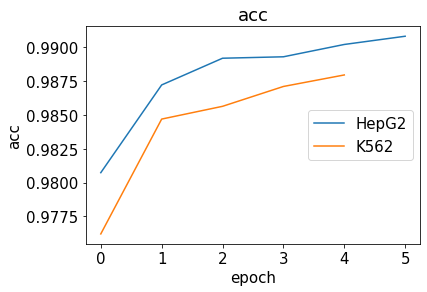

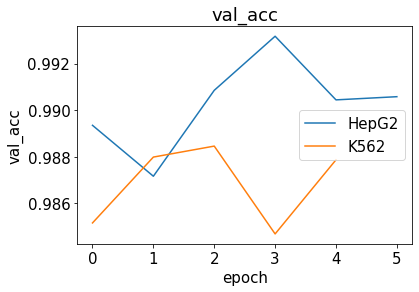

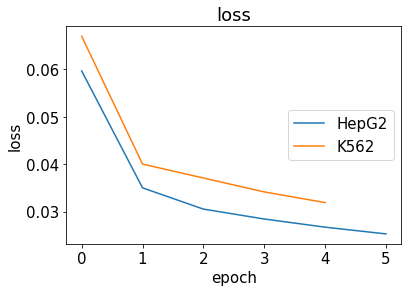

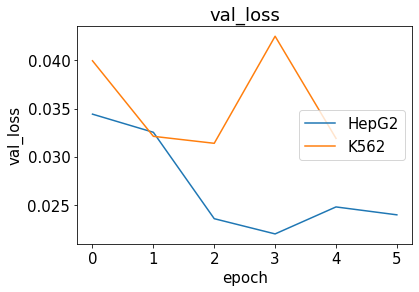

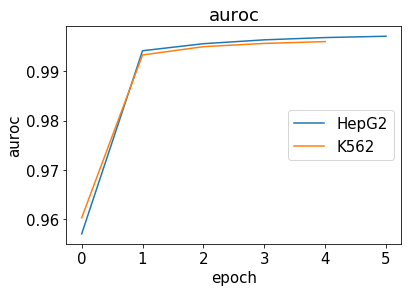

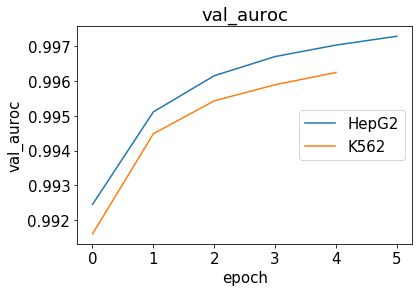

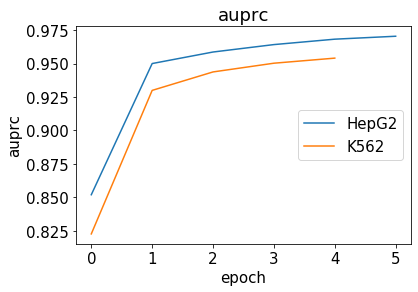

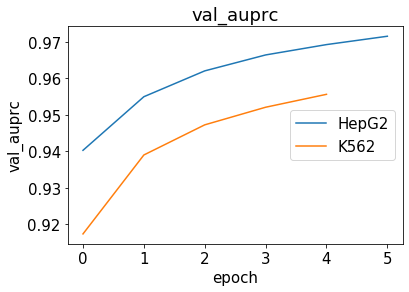

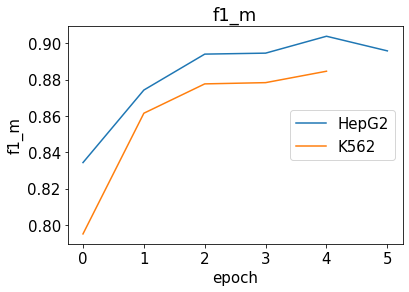

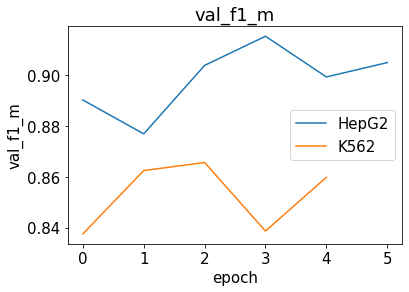

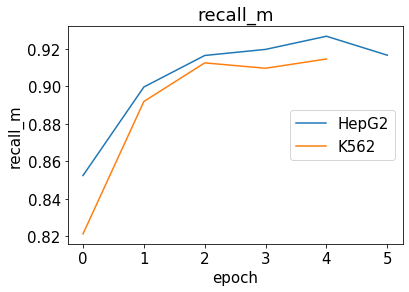

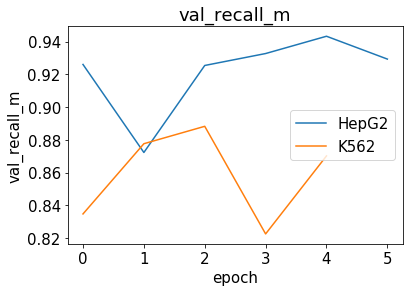

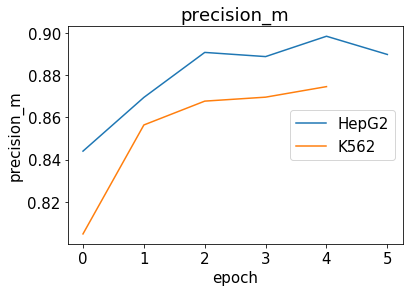

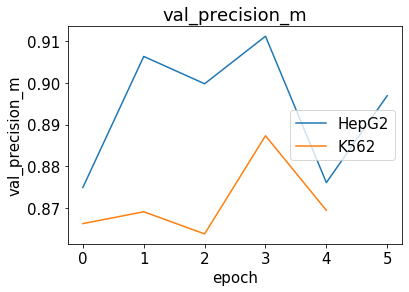

In [6]:
benchmarks = ['acc', 'val_acc', 
              'loss', 'val_loss', 
              'auroc', 'val_auroc', 
              'auprc', 'val_auprc', 
              'f1_m', 'val_f1_m',
              'recall_m', 'val_recall_m',
              'precision_m', 'val_precision_m']
for i in benchmarks:
    plt.figure()
    plt.rcParams["font.size"] = 15
    for h in history_list:
        plt.plot(np.array(h.history[i]))
    plt.title(i)
    plt.ylabel(i)
    plt.xlabel('epoch')
    plt.legend(args.cell_types, loc='center right')
    #plt.savefig(figure_output_name + '.' + i + '.png')

In [7]:
#collect all predictions for benchmark evaluation
y_test_out = []
y_pred_out = []
for j in range(len(y_test_list)):
    print(len(y_test_list[j]), len(y_pred_list[j]), type(y_test_list[j]))
    y_test_out.extend(y_test_list[j])
    y_pred_out.extend(y_pred_list[j])

84909 84909 <class 'numpy.ndarray'>
73238 73238 <class 'numpy.ndarray'>


2 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


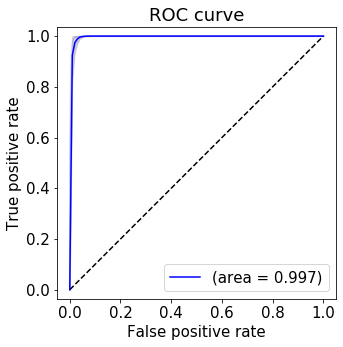

In [8]:
# ROC in test set
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 15
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(y_test_list)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_list[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(y_test_list[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)


print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='(area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

2 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


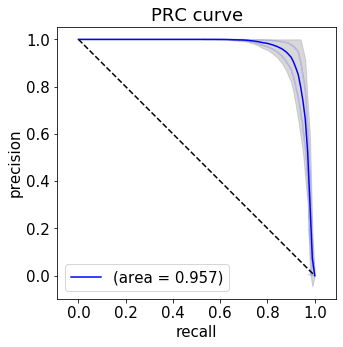

In [9]:
# PRC in test set
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 15
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(y_test_list)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(y_test_list[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(y_test_list[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='(area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [10]:
print("validation accuracy: " + str(np.mean(np.array(accuracy_list))))
print("validation auROC: " + str(np.mean(np.array(auroc_list))))
print("validation auPRC: " + str(np.mean(np.array(auprc_list))))

validation accuracy: 0.9830699016236211
validation auROC: 0.9965403715771257
validation auPRC: 0.9571245930997379
